# Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Initialize & Loading Data

In [2]:
Init_LR = 1e-4
Epochs = 5
BS = 32

Directory = r'D:\Abdulrhman Osama\Deep Learning Projects\Face Mask Detection\Data'
Categories = ['With_Mask', 'Without_Mask']

In [3]:
print('[INFO] Loading Images...')

data = []
labels = []

for category in Categories:
    
    path = os.path.join(Directory, category)
    for img in os.listdir(path):
        
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

print('[INFO] Images Is Loaded.')

[INFO] Loading Images...
[INFO] Images Is Loaded.


# Splitting Data

In [4]:
lb = LabelBinarizer()

labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = 'float32')
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

# Data Generator (Augmentation)

In [5]:
aug = ImageDataGenerator(
                            rotation_range = 20,
                            zoom_range = 0.15,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.15,
                            horizontal_flip = True,
                            fill_mode = 'nearest')

# Loading MobileNetV2 Model

In [6]:
baseModel = MobileNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (224, 224, 3)))

C:\Users\Abdulrhman Osama\AppData\Local\Temp\ipykernel_13064\1212084266.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (224, 224, 3)))


# Making Our Tiny Neural Network

In [7]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(128, activation = 'relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = 'softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Model Compiling

In [9]:
for layer in baseModel.layers:
    layer.trainable = False
    
    
print('[INFO] Compiling Model...')
opt = Adam(learning_rate = Init_LR, weight_decay = Init_LR / Epochs)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

print('[INFO] Model Compiling is Done.')

[INFO] Compiling Model...
[INFO] Model Compiling is Done.


# Training the Head of the Neural Network

In [10]:
print('[INFO] Training Head...')

H = model.fit(
                aug.flow(trainX, trainY, batch_size = BS),
                steps_per_epoch = len(trainX) // BS,
                validation_data = (testX, testY),
                validation_steps = len(testX) // BS,
                epochs = Epochs)

print('[INFO] Training Head is Done.')

[INFO] Training Head...
Epoch 1/5


D:\Abdulrhman Osama\Anaconda Navigator\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9139 - loss: 0.2405

D:\Abdulrhman Osama\Anaconda Navigator\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


508/508 ━━━━━━━━━━━━━━━━━━━━ 486s 928ms/step - accuracy: 0.9140 - loss: 0.2403 - val_accuracy: 0.9912 - val_loss: 0.0277
Epoch 2/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9912 - val_loss: 0.0277
Epoch 3/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 440s 861ms/step - accuracy: 0.9861 - loss: 0.0457 - val_accuracy: 0.9926 - val_loss: 0.0224
Epoch 4/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 68s 134ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9926 - val_loss: 0.0224
Epoch 5/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 431s 843ms/step - accuracy: 0.9896 - loss: 0.0324 - val_accuracy: 0.9929 - val_loss: 0.0203
[INFO] Training Head is Done.


# Making Predictions on the Testing Set

In [11]:
print('[INFO] Evaluating Neural Network...')
Predictions = model.predict(testX, batch_size = BS)

Predictions = np.argmax(Predictions, axis = 1)
print(classification_report(testY.argmax(axis = 1), Predictions, target_names = lb.classes_))

print('[INFO] Evaluating Neural Network is Done.')

print('[INFO] Saving Mask Detector Model...')
model.save('D:\Abdulrhman Osama\Deep Learning Projects\Face Mask Detection\Mask_Detector.h5')
print('[INFO] Mask Detector Model is Saved.')

[INFO] Evaluating Neural Network...
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 566ms/step


              precision    recall  f1-score   support

   With_Mask       0.99      0.99      0.99      2022
Without_Mask       0.99      0.99      0.99      2048

    accuracy                           0.99      4070
   macro avg       0.99      0.99      0.99      4070
weighted avg       0.99      0.99      0.99      4070

[INFO] Evaluating Neural Network is Done.
[INFO] Saving Mask Detector Model...
[INFO] Mask Detector Model is Saved.


# Plotting Training Loss & Accuracy

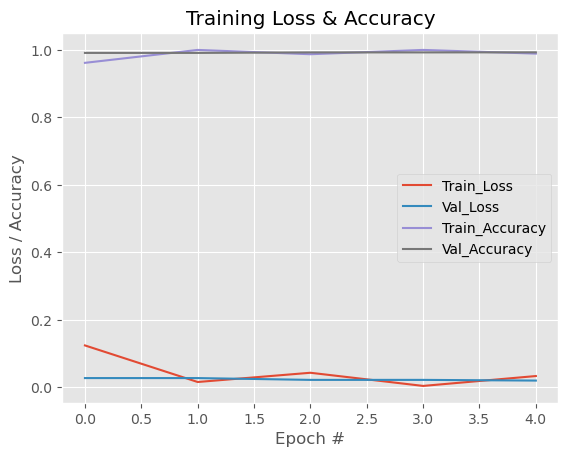

In [12]:
N = Epochs

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label = 'Train_Loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label = 'Val_Loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label = 'Train_Accuracy')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label = 'Val_Accuracy')

plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.legend(loc = 'best')
plt.savefig('plot.png')

# Thank You

# Eng. Abdulrhman Osama